In [1]:
import numpy as np
import scipy as sp
import dask
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import time

# Data Processing

## Read WWLLN data

In [5]:
wwlln_dataset = xr.open_mfdataset('/home/wei/data/WWLLN/Global/WWLLN_20*.nc', parallel=True)

In [6]:
wwlln_dataset

<xarray.Dataset>
Dimensions:  (Time: 20456, lat: 180, lon: 360)
Coordinates:
  * Time     (Time) datetime64[ns] 2010-01-01 ... 2016-12-31T21:00:00
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    F        (Time, lat, lon) float32 dask.array<chunksize=(2920, 180, 360), meta=np.ndarray>
Attributes:
    creation_date:  Tue Jul 14 01:12:10 PDT 2020
    Conventions:    None
    title:          level 1 analysis

In [7]:
Fdata = wwlln_dataset.F.resample(Time='1D').sum()

In [8]:
Fdata

<xarray.DataArray 'F' (Time: 2557, lat: 180, lon: 360)>
dask.array<stack, shape=(2557, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 2010-01-01 2010-01-02 ... 2016-12-31
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

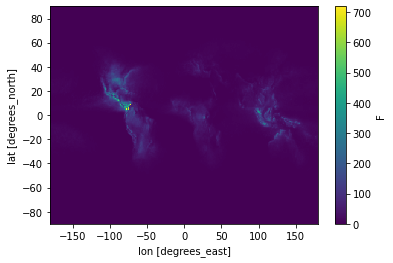

In [9]:
Fdata[:,:,:].mean(dim='Time').plot()

# Read island data

In [ ]:
island_dataset = xr.open_dataset('/home/wei/data/island/island_1deg.nc')

In [ ]:
island_dataset

## Read GEFS data

In [10]:
#gefs_dataset = xr.open_mfdataset('/home/wei/data/GEFS/GEFS*.nc', parallel=True)\
#                 .squeeze(dim='P')\
#                 .rename({'X': 'lon','Y': 'lat'})
gefs_dataset = xr.open_mfdataset('/home/wei/data/GEFS/GEFS*.nc', parallel=True)\
                 .rename({'X': 'lon','Y': 'lat'})
gefs_dataset = gefs_dataset.assign_coords(lon=(((gefs_dataset.lon + 180) % 360) - 180))

In [11]:
gefs_dataset

<xarray.Dataset>
Dimensions:  (L: 35, M: 11, S: 365, lat: 181, lon: 360)
Coordinates:
  * S        (S) datetime64[ns] 2010-01-06 2010-01-13 ... 2016-12-21 2016-12-28
  * M        (M) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... -5.0 -4.0 -3.0 -2.0 -1.0
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
Data variables:
    cape     (S, M, L, lat, lon) float32 dask.array<chunksize=(365, 11, 35, 181, 360), meta=np.ndarray>
    pr       (S, M, L, lat, lon) float32 dask.array<chunksize=(365, 11, 35, 181, 360), meta=np.ndarray>

# Create CP data

In [12]:
def multiply(a, b):
    func = lambda x, y: x * y 
    return xr.apply_ufunc(func, a, b, dask="parallelized")

In [13]:
cp_data = multiply(gefs_dataset.cape, gefs_dataset.pr)

In [14]:
cp_data

<xarray.DataArray (S: 365, M: 11, L: 35, lat: 181, lon: 360)>
dask.array<transpose, shape=(365, 11, 35, 181, 360), dtype=float32, chunksize=(365, 11, 35, 181, 360), chunktype=numpy.ndarray>
Coordinates:
  * S        (S) datetime64[ns] 2010-01-06 2010-01-13 ... 2016-12-21 2016-12-28
  * M        (M) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... -5.0 -4.0 -3.0 -2.0 -1.0
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0

# TK18: Fig 1

## Generate cp_data_SMLmean dataset

In [19]:
#cp_data_SMLmean = cp_data.mean(dim={'S','M','L'})

In [20]:
#cp_data_SMLmean

<xarray.DataArray (lat: 181, lon: 360)>
dask.array<mean_agg-aggregate, shape=(181, 360), dtype=float32, chunksize=(181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... -5.0 -4.0 -3.0 -2.0 -1.0
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0

In [21]:
#start = time.time()
#cp_data_SMLmean.persist()
#end = time.time()
#print(end - start)

500.9464797973633


In [22]:
#cp_data_SMLmean

<xarray.DataArray (lat: 181, lon: 360)>
dask.array<mean_agg-aggregate, shape=(181, 360), dtype=float32, chunksize=(181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... -5.0 -4.0 -3.0 -2.0 -1.0
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0

In [23]:
#lono = xr.DataArray(np.linspace(-179.5,179.5,360), dims='lon')
#lato = xr.DataArray(np.linspace(-89.5,89.5,180), dims='lat')

#with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#    cp_data_SMLmean = cp_data_SMLmean.interp(lon=lono,lat=lato,method='linear')

In [24]:
#start = time.time()
#cp_data_SMLmean.to_netcdf('/home/wei/data/metadata/cp_data_SMLmean.nc',mode='w')
#end = time.time()
#print(end - start)

524.962185382843


## Read cp_data_SMLmean dataset

In [15]:
cp_data_SMLmean = xr.open_dataarray('/home/wei/data/metadata/cp_data_SMLmean.nc')

In [16]:
cp_data_SMLmean.persist()
cp_data_SMLmean

<xarray.DataArray (lat: 180, lon: 360)>
array([[1.243908e-06, 1.234186e-06, 1.224872e-06, ..., 1.272014e-06,
        1.263634e-06,          nan],
       [1.323400e-06, 1.314604e-06, 1.304804e-06, ..., 1.344008e-06,
        1.338285e-06,          nan],
       [1.393322e-06, 1.330683e-06, 1.261561e-06, ..., 1.409908e-06,
        1.431973e-06,          nan],
       ...,
       [2.281429e-06, 2.277863e-06, 2.277491e-06, ..., 2.300702e-06,
        2.296897e-06,          nan],
       [2.390738e-06, 2.390079e-06, 2.391059e-06, ..., 2.389084e-06,
        2.387412e-06,          nan],
       [2.321523e-06, 2.321335e-06, 2.321959e-06, ..., 2.322257e-06,
        2.322341e-06,          nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

0.048899173736572266


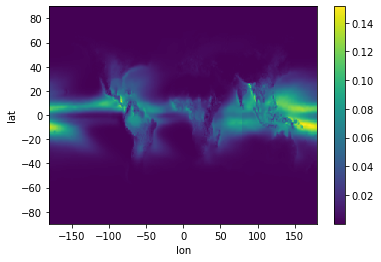

In [16]:
start = time.time()
cp_data_SMLmean.plot()
end = time.time()
print(end - start)

## Plotting

In [17]:
import cartopy.crs as ccrs
import regionmask
import geopandas as gpd

import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
def plot_map(figsize,data,cmap,vmin=None,vmax=None,title=None,unit=None):
    
    plt.rcParams.update({'font.size': 48})
    
    xlim    = (-125,-65)
    ylim    = (25,50)
    
    pcm = xr.plot.pcolormesh(data,"lon","lat",
                             figsize=figsize,
                             xlim=xlim,
                             ylim=ylim,
                             cmap=cmap,
                             vmin=vmin,
                             vmax=vmax,
                             add_colorbar=True,
                            )

    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')

In [ ]:
def plot_timeseries(figsize,data,cmap,vmin=None,vmax=None,title=None,unit=None):
    
    fig   = plt.figure(figsize=figsize)


### Set CONUS filter

In [19]:
PATH_TO_SHAPEFILE = '/home/wei/data/WorldCountriesBoundaries/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)
indexes = np.arange(250).tolist()
countries_mask_poly = regionmask.Regions_cls(name = 'COUNTRY', numbers = indexes, names = countries.CNTRY_NAME[indexes], abbrevs = countries.CNTRY_NAME[indexes], outlines = list(countries.geometry.values[i] for i in range(0,countries.shape[0])))

/home/wei/.anaconda3/envs/test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: FutureWarning: Using 'Regions_cls' is deprecated, please use 'Regions' instead. Please note that the call signature is different.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
mask = countries_mask_poly.mask(Fdata.isel(Time = 0), lat_name='lat', lon_name='lon')
mask = mask.where( (mask==232) & (mask.lat<49.35) & (mask.lat>24.74)  & (mask.lon>-124.78) & (mask.lon<-66.95) )

## Figure 1a

In [21]:
data1a = Fdata.mean(dim='Time').where( ~np.isnan(mask) ).persist()

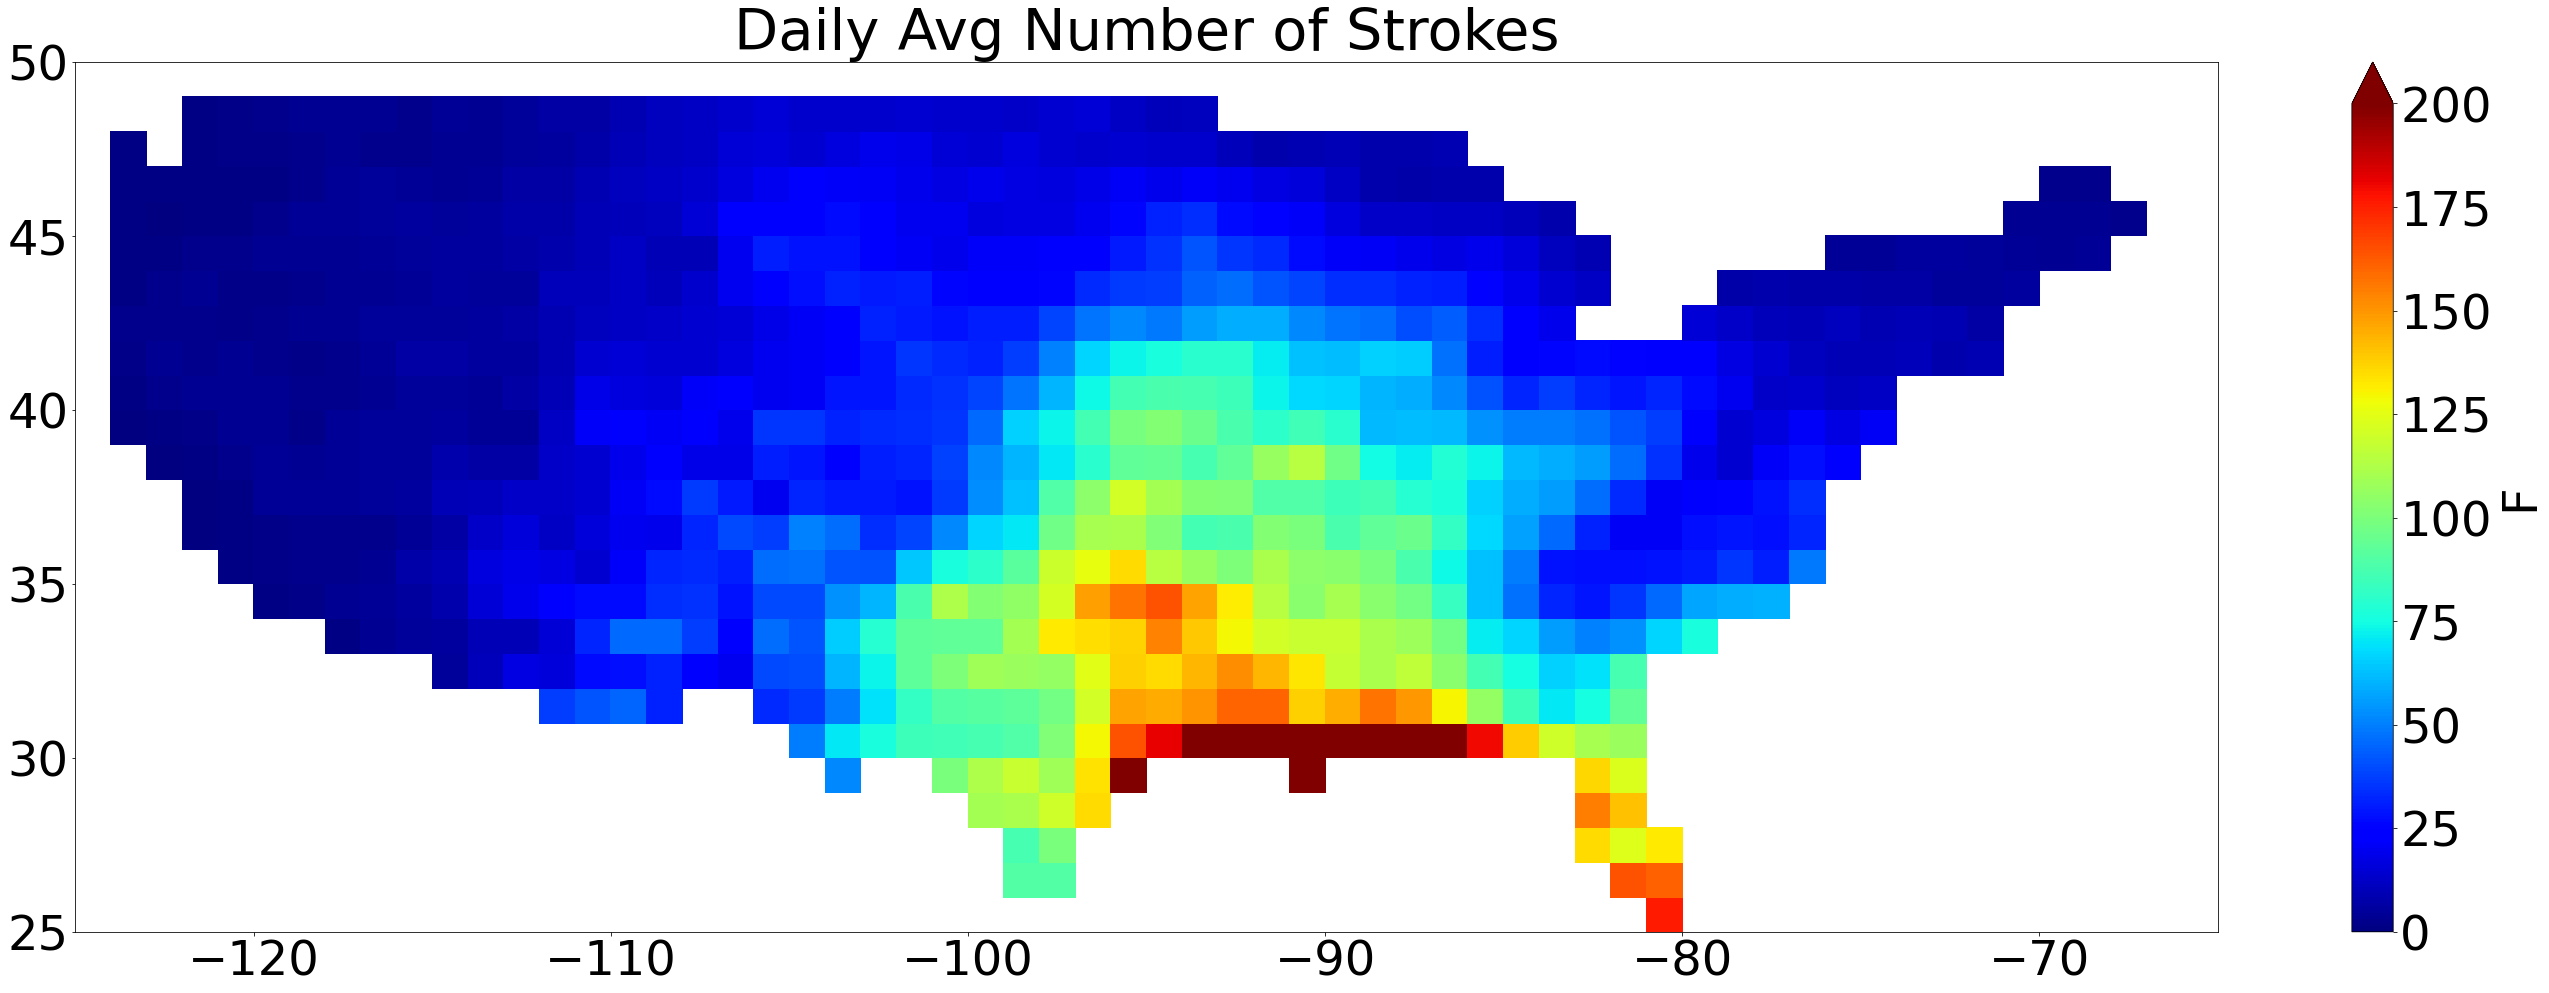

In [22]:
figsize = (48,16)
cmap    = plt.get_cmap('jet')
vmin    = 0
vmax    = 200
title   = 'Daily Avg Number of Strokes'
unit    = ''

plot_map(figsize,data1a,cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)
plt.savefig('TK18_Fig1a.png')

## Figure 1b

In [23]:
data1b = cp_data_SMLmean.where( ~np.isnan(mask) ).persist()

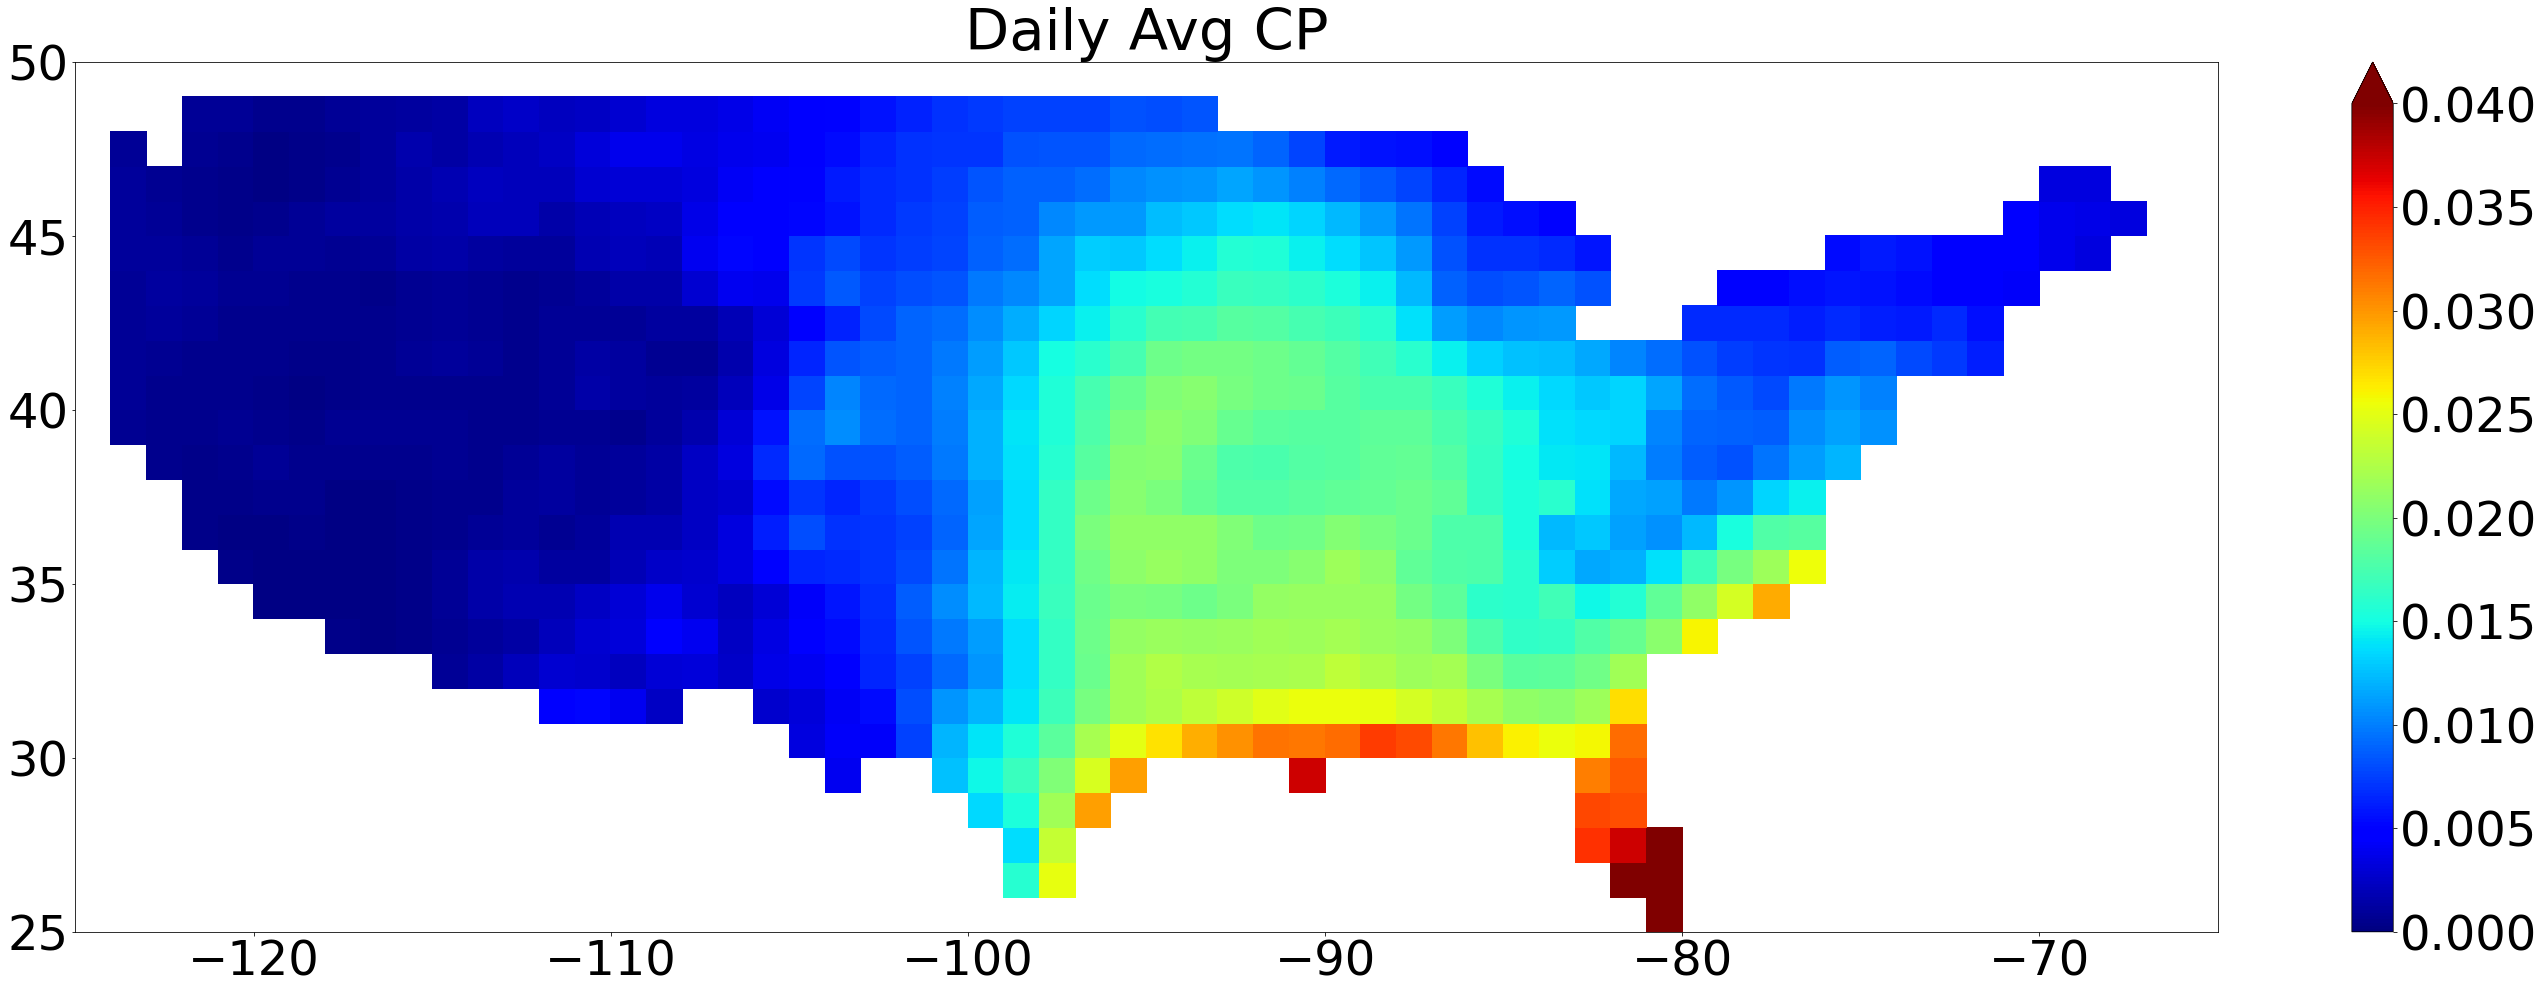

In [24]:
figsize = (48,16)
cmap    = plt.get_cmap('jet')
vmin    = 0
vmax    = 0.04
title   = 'Daily Avg CP'
unit    = ''

plot_map(figsize,data=data1b,cmap=cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)
plt.savefig('TK18_Fig1b.png')

## Figure 1c

In [25]:
data1c = Fdata.where( ~np.isnan(mask) ).sum(dim={'lat','lon'}).isel(Time=slice(365,730)).persist()

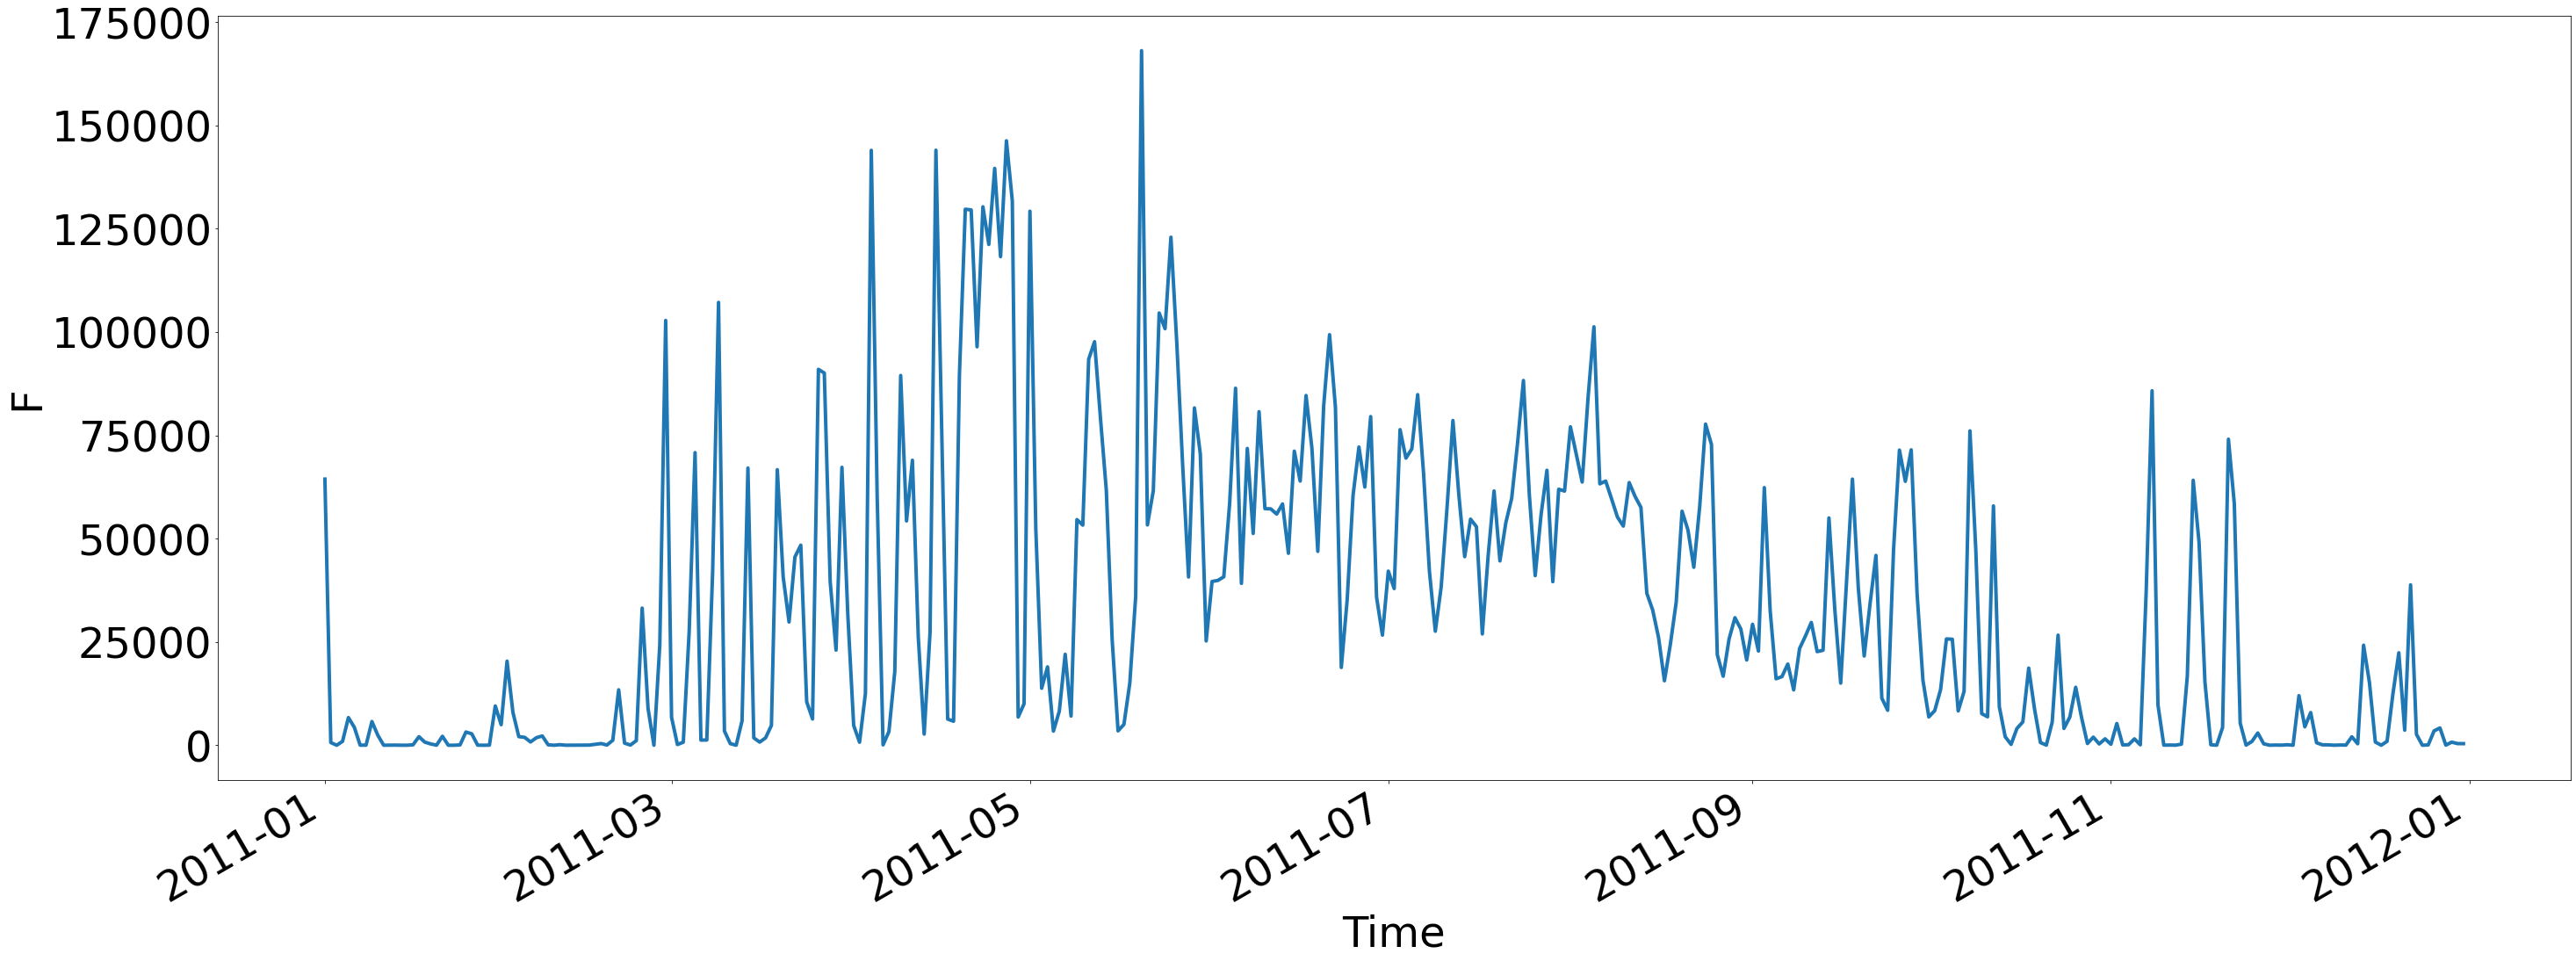

In [26]:
figsize = (48,16)

xr.plot.line(data1c,
             figsize=figsize,
             linewidth=4,
            )
plt.savefig('TK18_Fig1c.png')

## Figure 1d

In [27]:
data1d = Fdata.where( (Fdata>0) & (~np.isnan(mask)) ).count(dim={'lat','lon'}).persist()

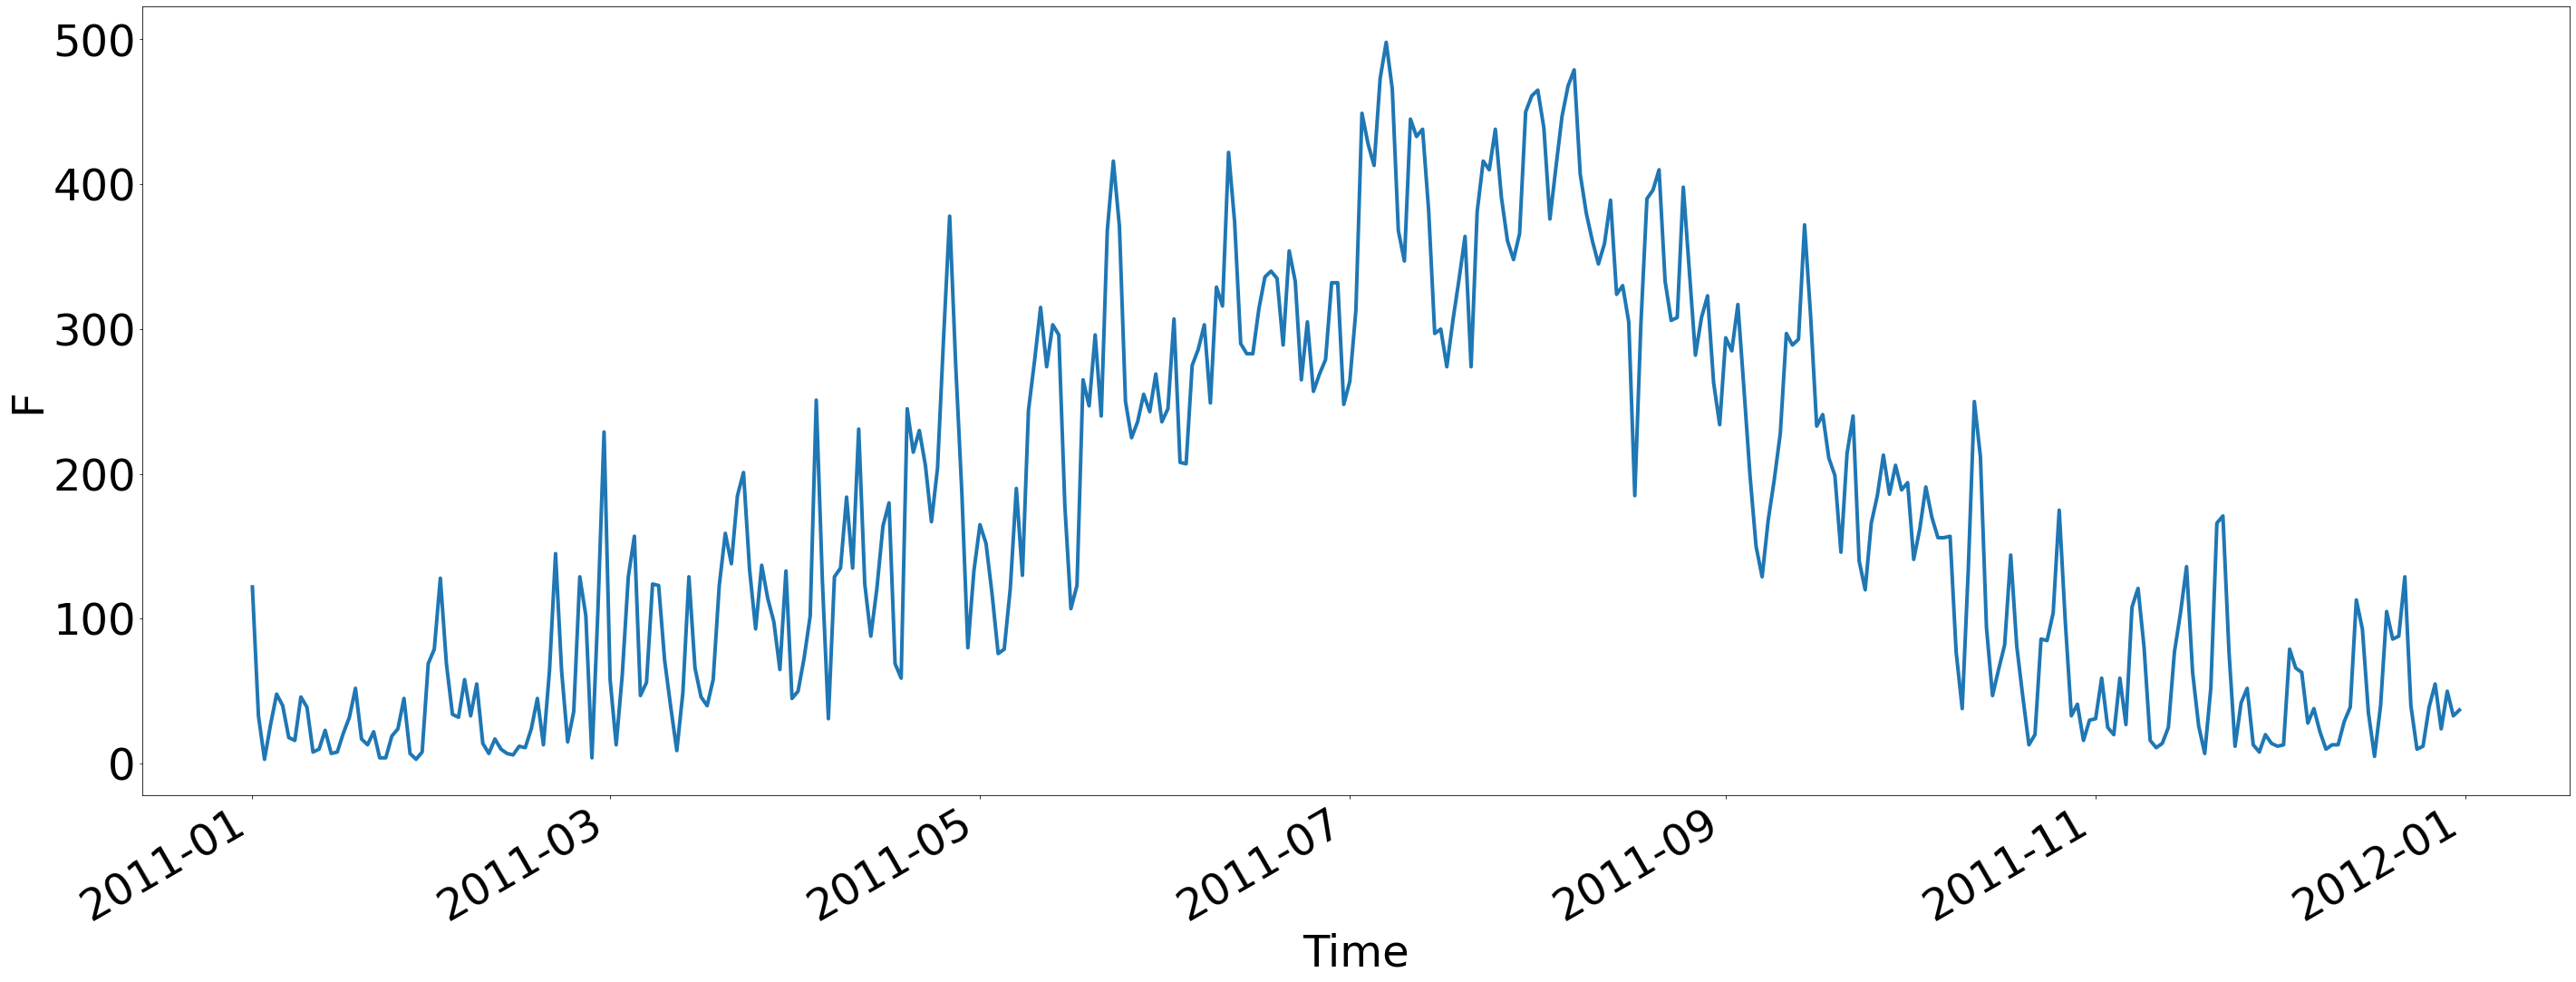

In [28]:
figsize = (48,16)

xr.plot.line(data1d.isel(Time=slice(365,730)),
             figsize=figsize,
             linewidth=4,
            )
plt.savefig('TK18_Fig1d.png')